In [39]:
%pip install langchain_google_genai

  Using cached grpcio-1.74.0-cp313-cp313-macosx_11_0_universal2.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 8.1 MB/s eta 0:00:00
Using cached grpcio-1.74.0-cp313-cp313-macosx_11_0_universal2.whl (11.0 MB)
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.70.0
    Uninstalling grpcio-1.70.0:
      Successfully uninstalled grpcio-1.70.0
  Attempting uninstall: google-ai-generativelanguage━━━━━━━━━━━━━━ 1/4 [grpcio]
    Found existing installation: google-ai-generativelanguage 0.6.151/4 [grpcio]
    Uninstalling google-ai-generativelanguage-0.6.15:━━━━━━━━━━━━━ 2/4 [google-ai-generativelanguage]
      Successfully uninstalled google-ai-generativelanguage-0.6.15 2/4 [google-ai-generativelanguage]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [langchain_google_genai]hain_google_genai]guage]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the fo

In [54]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
# from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel
import random
import os

In [43]:
load_dotenv(override=True)

True

In [44]:
nouns=["Cabbages","Unicorns","Toasters","Penguins","Bananas","Zombies","Rainbows","Eels","Pickles","Muffins"]
adjectives=["outrageous","smelly","pedantic","existential","moody","sparkly","untrustworthy","sarcastic","squishy","haunted"]

In [45]:
# def shout(text:str) -> str:
#     print(text.upper())
#     return text.upper()


def shout(text:Annotated[str,"something to be shouted"]) -> str:
    print(text.upper())
    return text.upper()

shout("Hello")

HELLO


'HELLO'

<h3>Annotated</h3><br>
Type hinting is a feature in Python that lets you specify the type of something:

my_favorite_things: List

But we can also use something called "Annotated" to add extra information that somebody else might find useful:

my_favorite_things: Annotated[List, "these are a few of mine"]

LangGraph uses this feature when we define our State object.

It wants us to tell it what function it should call to update the State with a new value.

This function is called a reducer.

LangGraph provides a default reducer called add_messages which takes care of the most common case.

In [46]:
# Step 1: Define the State Object

class State(BaseModel):
    messages: Annotated[list,add_messages]

In [47]:
# Step 2: Start the Graph Builder with this State class
graph_builder=StateGraph(State)

In [48]:
#  Step 3: Create a Node

def our_first_node(state: State) -> State:
    reply = f"{random.choice(nouns)} are {random.choice(adjectives)}"
    messages = [{"role": "assistant", "content": reply}]

    new_state = State(messages=messages)
    return new_state


graph_builder.add_node("first_node",our_first_node)

In [49]:
# Step 4: Create Edges
graph_builder.add_edge(START,"first_node")
graph_builder.add_edge("first_node",END)

In [50]:
# Step 5: Complie the Graph
graph=graph_builder.compile()

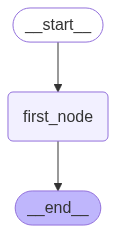

In [51]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
def chat(user_input:str,history):
    message={"role":"user","content":user_input}
    messages=[message]
    state=State(messages=messages)
    result=graph.invoke(state)
    print(result)
    return result["messages"][-1].content

gr.ChatInterface(chat,type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='09753ab5-4f5f-48be-8086-3bdbbb8e2488'), AIMessage(content='Eels are haunted', additional_kwargs={}, response_metadata={}, id='5cd1f351-ffe9-47c8-99ed-8d5df07509a3')]}
{'messages': [HumanMessage(content='Are you serious?', additional_kwargs={}, response_metadata={}, id='3c2b96d7-a203-420b-a50a-0427ffe82871'), AIMessage(content='Penguins are haunted', additional_kwargs={}, response_metadata={}, id='72513d17-648f-4860-abf9-baad9ba01963')]}
{'messages': [HumanMessage(content='what are you talking', additional_kwargs={}, response_metadata={}, id='e7714079-b89c-45a5-9ddc-6e44010aa0a8'), AIMessage(content='Rainbows are smelly', additional_kwargs={}, response_metadata={}, id='2e9f3f9c-fa09-4a32-a67f-0112a8a50e4d')]}
{'messages': [HumanMessage(content='really?', additional_kwargs={}, response_metadata={}, id='da01c2f5-38f1-4ca5-8b06-9b6225080000'), AIMessage(content='Rainbows are untrustworthy', additional_

<h3>Now we will follow all the five steps one more time with llm integrated into it</h3>

In [52]:
class State(BaseModel):
    messages:Annotated[list, add_messages]

In [53]:
graph_builder=StateGraph(State)

In [55]:
llm=ChatGoogleGenerativeAI(model="gemini-2.0-flash-001",google_api_key=os.getenv('GEMINI_ACCESS_KEY'))


def chatbot_node(old_state: State) -> State:
    response=llm.invoke(old_state.messages)
    new_state=State(messages=[response])
    return new_state

graph_builder.add_node("chatbot",chatbot_node)

In [56]:
graph_builder.add_edge(START,"chatbot")
graph_builder.add_edge("chatbot",END)

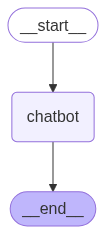

In [57]:
graph=graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
def chat(user_input:str,history):
    initial_state=State(messages=[{"role":"user","content":user_input}])
    result=graph.invoke(initial_state)
    print(result)
    return result['messages'][-1].content

gr.ChatInterface(chat,type="messages").launch()